In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# WGAN

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
import gzip
# torch.cuda.set_device(3)

Download the LSUN scene classification dataset bedroom category, unzip it, and convert it to jpg files (the scripts folder is here in the `dl2` folder):

```
curl 'http://lsun.cs.princeton.edu/htbin/download.cgi?tag=latest&category=bedroom&set=train' -o bedroom.zip
unzip bedroom.zip
pip install lmdb
python lsun-data.py {PATH}/bedroom_train_lmdb --out_dir {PATH}/bedroom
```

This isn't tested on Windows - if it doesn't work, you could use a Linux box to convert the files, then copy them over. Alternatively, you can download [this 20% sample](https://www.kaggle.com/jhoward/lsun_bedroom) from Kaggle datasets.

In [3]:
PATH = Path('data/lsun/')
IMG_PATH = PATH/'bedroom'
CSV_PATH = PATH/'files.csv'
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [69]:
files = PATH.glob('bedroom/**/*.jpg')

with CSV_PATH.open('w') as fo:
    for f in files: fo.write(f'{f.relative_to(IMG_PATH)},0\n')

In [5]:
# Optional - sampling a subset of files
CSV_PATH = PATH/'files_sample.csv'

In [79]:
files = PATH.glob('bedroom/**/*.jpg')

with CSV_PATH.open('w') as fo:
    for f in files:
        if random.random()<0.1: fo.write(f'{f.relative_to(IMG_PATH)},0\n')

## Discriminator

inputs an image and output is a number -> (real ----- fake)

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, ni, no, ks, stride, bn=True, pad=None):
        super().__init__()
        if pad is None: pad = ks//2//stride
        self.conv = nn.Conv2d(ni, no, ks, stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(no) if bn else None
        self.relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [5]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nc, ndf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.initial = ConvBlock(nc, ndf, 4, 2, bn=False)
        csize,cndf = isize/2,ndf
        self.extra = nn.Sequential(*[ConvBlock(cndf, cndf, 3, 1)
                                    for t in range(n_extra_layers)])

        pyr_layers = []
        # keep using stride 2 convolutions to decrease the grid size down to 4
        while csize > 4:
            pyr_layers.append(ConvBlock(cndf, cndf*2, 4, 2))
            cndf *= 2; csize /= 2
        self.pyramid = nn.Sequential(*pyr_layers)
        
        self.final = nn.Conv2d(cndf, 1, 4, padding=0, bias=False)
        # final layer is conv instead of linear: ~4x4x1

    def forward(self, input):
        x = self.initial(input)
        x = self.extra(x)
        x = self.pyramid(x)
        return self.final(x).mean(0).view(1)
        # take the mean of that -> scalar value
        
    # could also try adaptive average pooling, fully connected layer to get our one number out...

## Generator

Input: vector of random numbers (prime) -> different numbers generate different images
Output: rank 3 tensor (not including batch size), HxWx3 (3 channels)
- need to use a deconvolution (transposed convolution in pytorch); ~calculation of the gradient of a convolution

In [6]:
# identical to conv block except for the transpose
# stride 2 e.g. doubles size instead of halving...
class DeconvBlock(nn.Module): 
    def __init__(self, ni, no, ks, stride, pad, bn=True):
        super().__init__()
        
        self.conv = nn.ConvTranspose2d(ni, no, ks, stride, padding=pad, bias=False)
        # nn.upsample could work here instead of ConvTranspose... (opposite of pooling) -- not great for GANs
        #nn.Upsample(scale_factor=2)
        #nn.Conv2d(ni,no,3,stride=1)
        
        self.bn = nn.BatchNorm2d(no)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv(x))
        return self.bn(x) if self.bn else x

In [7]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        super().__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize!=isize: cngf*=2; tisize*=2
        layers = [DeconvBlock(nz, cngf, 4, 1, 0)]

        # increase cell size by 2 until half the size of desired output
        csize, cndf = 4, cngf
        while csize < isize//2:
            layers.append(DeconvBlock(cngf, cngf//2, 4, 2, 1))
            cngf //= 2; csize *= 2

        # add on n_layers of no stride
        layers += [DeconvBlock(cngf, cngf, 3, 1, 1) for t in range(n_extra_layers)]
        # add final deconv to get to desired output
        layers.append(nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        self.features = nn.Sequential(*layers)

    def forward(self, input): return F.tanh(self.features(input))

In [8]:
bs,sz,nz = 64,64,100

In [9]:
tfms = tfms_from_stats(inception_stats, sz)
md = ImageClassifierData.from_csv(PATH, 'bedroom', CSV_PATH, tfms=tfms, bs=128,
                                  skip_header=False, continuous=True)

In [10]:
md = md.resize(128)

A Jupyter Widget

### Check data loader

In [11]:
x,_ = next(iter(md.val_dl))

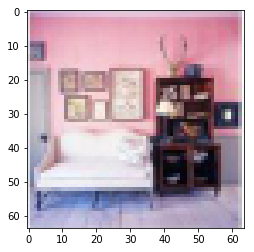

In [15]:
plt.imshow(md.trn_ds.denorm(x)[0]);

In [15]:
netG = DCGAN_G(sz, nz, 3, 64, 1).cuda()
netD = DCGAN_D(sz, 3, 64, 1).cuda()

In [16]:
def create_noise(b): return V(torch.zeros(b, nz, 1, 1).normal_(0, 1))
# nz: size of noise vector
# return a variable of normally distributed noise -> template we're going to modify via backprop to generate image

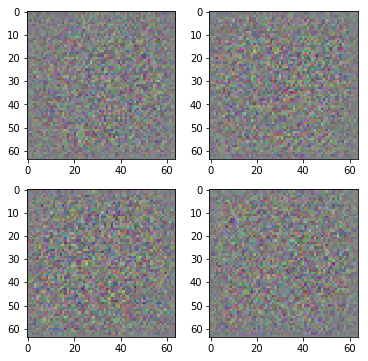

In [17]:
preds = netG(create_noise(4))
pred_ims = md.trn_ds.denorm(preds)

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i,ax in enumerate(axes.flat): ax.imshow(pred_ims[i])

## WGAN Training Loop

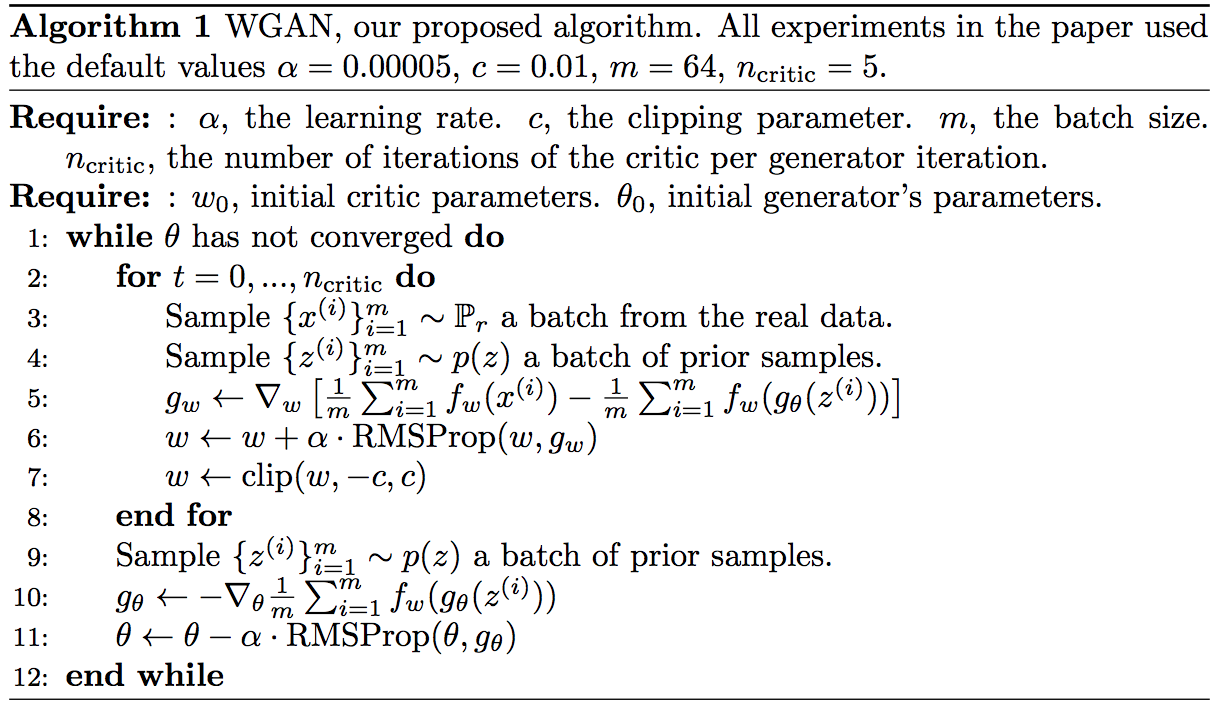

1: while loop for an epoch  
2: loop through the discriminator (critic)  (5 times)
3: get random minibatch of real data  (bs = 64)
4: get random minibatch of generated data (priors)  
5: get gradients of ( mean of netD(real) - mean of netD(fake) )  
6: optimize w/ RMSProp and lr=5e-5

In [19]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

In [20]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in trange(niter):
        # set models into training mode to train (batchnorm updates, dropout)
        netD.train(); netG.train()
        data_iter = iter(md.trn_dl)
        i,n = 0,len(md.trn_dl)
        with tqdm(total=n) as pbar:  # progress bar
            # while theta has not converged do:
            while i < n:
                set_trainable(netD, True)
                set_trainable(netG, False)
                d_iters = 100 if (first and (gen_iterations < 25) or (gen_iterations % 500 == 0)) else 5
                # early on and occasionally throughout do more loops of the discriminator.
                # Generated results are only as good as the discriminator.
                j = 0
                # discriminator (critic) loop
                while (j < d_iters) and (i < n):
                    # to start out we're discriminating btw random noise and an actual image
                    j += 1; i += 1
                    for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)  # line 7 - need to keep weights w/in range
                    # this is the key modification of a WassersteinGAN -> there are better ways to do this now...
                    real = V(next(data_iter)[0])    # batch of real images
                    real_loss = netD(real)          # calculate loss for real images
                    fake = netG(create_noise(real.size(0)))   # generate fake images
                    fake_loss = netD(V(fake.data))            # calculate loss for fakes
                    netD.zero_grad() 
                    lossD = real_loss-fake_loss   # line 5
                    lossD.backward()
                    optimizerD.step()
                    pbar.update()

                # one pass of the generator
                set_trainable(netD, False)
                set_trainable(netG, True)
                netG.zero_grad()
                lossG = netD(netG(create_noise(bs))) #.mean(0).view(1) - this is in the discriminator
                lossG.backward()
                optimizerG.step()
                gen_iterations += 1
            
        print(f'Loss_D {to_np(lossD)}; Loss_G {to_np(lossG)}; '
              f'D_real {to_np(real_loss)}; Loss_D_fake {to_np(fake_loss)}')

In [21]:
torch.backends.cudnn.benchmark=True

In [22]:
train(1, False)

100%|██████████| 18957/18957 [19:48<00:00, 10.74it/s]
Loss_D [-0.67574]; Loss_G [0.08612]; D_real [-0.1782]; Loss_D_fake [0.49754]
100%|██████████| 1/1 [19:49<00:00, 1189.02s/it]

In [24]:
set_trainable(netD, True)
set_trainable(netG, True)
# decrease lr and run through another epoch
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-5)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-5)

In [23]:
fixed_noise = create_noise(bs)

In [25]:
train(1, False)

100%|██████████| 18957/18957 [23:31<00:00, 13.43it/s]
Loss_D [-1.01657]; Loss_G [0.51333]; D_real [-0.50913]; Loss_D_fake [0.50744]
100%|██████████| 1/1 [23:31<00:00, 1411.84s/it]

### Check Generator Results

In [18]:
def gallery(x, nc=3):
    n,h,w,c = x.shape
    nr = n//nc
    assert n == nr*nc
    return (x.reshape(nr, nc, h, w, c)
              .swapaxes(1,2)
              .reshape(h*nr, w*nc, c))

In [23]:
fixed_noise = create_noise(bs)

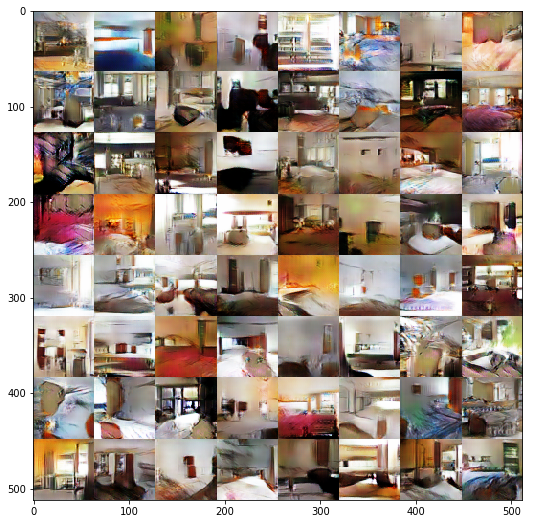

In [26]:
# set models into eval mode to evaluate
netD.eval(); netG.eval();
fake = netG(fixed_noise).data.cpu()
faked = np.clip(md.trn_ds.denorm(fake),0,1)

plt.figure(figsize=(9,9))
plt.imshow(gallery(faked, 8));

In [27]:
torch.save(netG.state_dict(), TMP_PATH/'netG_2.h5')
torch.save(netD.state_dict(), TMP_PATH/'netD_2.h5')